<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.7.1 True
0.23.0


## Run Inference with MMSeg trained weight

In [2]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [3]:
config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [4]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

/opt/ml/input/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:232: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


In [5]:
# test a single image
sample_img = '../data/mmseg/images/batch_01_vt_0010.jpg'
result = inference_segmentor(model, sample_img)

/opt/ml/input/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


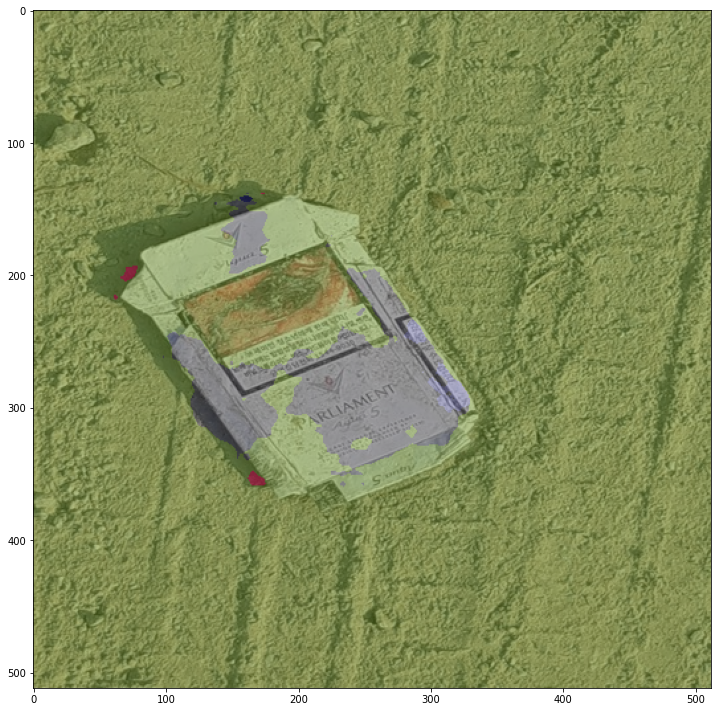

In [6]:
# show the results
show_result_pyplot(model, sample_img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

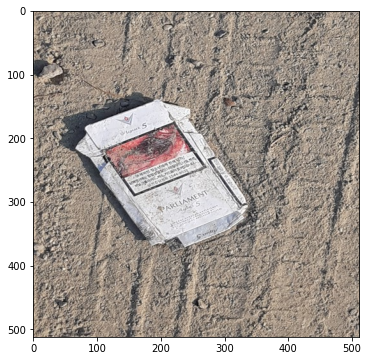

In [7]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread(sample_img)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [8]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '../data/mmseg'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('General trash','Paper','Paper pack','Metal','Glass','Plastic','Styrofoam','Plastic bag','Battery','Clothing')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51], [0, 241, 0],[0,0,241]]

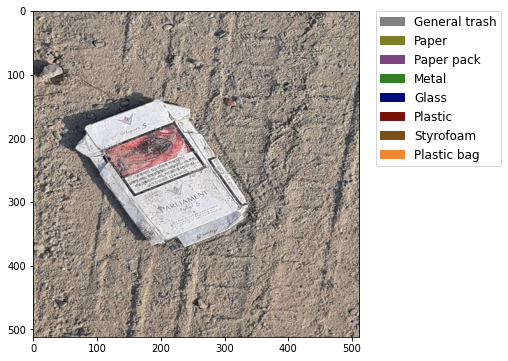

In [9]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open(sample_img)
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [11]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [12]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [13]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

### Train and Evaluation

In [14]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-04-26 09:02:08,164 - mmseg - INFO - Loaded 2617 images
/opt/ml/input/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2022-04-26 09:02:08,909 - mmseg - INFO - Loaded 655 images
2022-04-26 09:02:08,910 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2022-04-26 09:02:09,064 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shap

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 655/655, 23.1 task/s, elapsed: 28s, ETA:     0s

2022-04-26 09:03:26,959 - mmseg - INFO - per class results:
2022-04-26 09:03:26,961 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
| General trash | 77.21 |  98.7 |
|     Paper     | 13.55 | 17.23 |
|   Paper pack  | 51.01 | 71.68 |
|     Metal     |  0.0  |  0.0  |
|     Glass     |  0.0  |  0.0  |
|    Plastic    |  0.0  |  0.0  |
|   Styrofoam   |  3.0  |  3.11 |
|  Plastic bag  |  6.01 |  6.38 |
|    Battery    |  0.0  |  0.0  |
|    Clothing   |  0.0  |  0.0  |
+---------------+-------+-------+
2022-04-26 09:03:26,961 - mmseg - INFO - Summary:
2022-04-26 09:03:26,962 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.44 | 15.08 | 19.71 |
+-------+-------+-------+
2022-04-26 09:03:26,964 - mmseg - INFO - Iter(val) [655]	aAcc: 0.7644, mIoU: 0.1508, mAcc: 0.1971, IoU.General trash: 0.7721, IoU.Paper: 0.1355, IoU.Paper pack: 0.5101, IoU.Metal: 0.0000, IoU.Glass: 0

Inference with trained model

<Figure size 576x432 with 0 Axes>

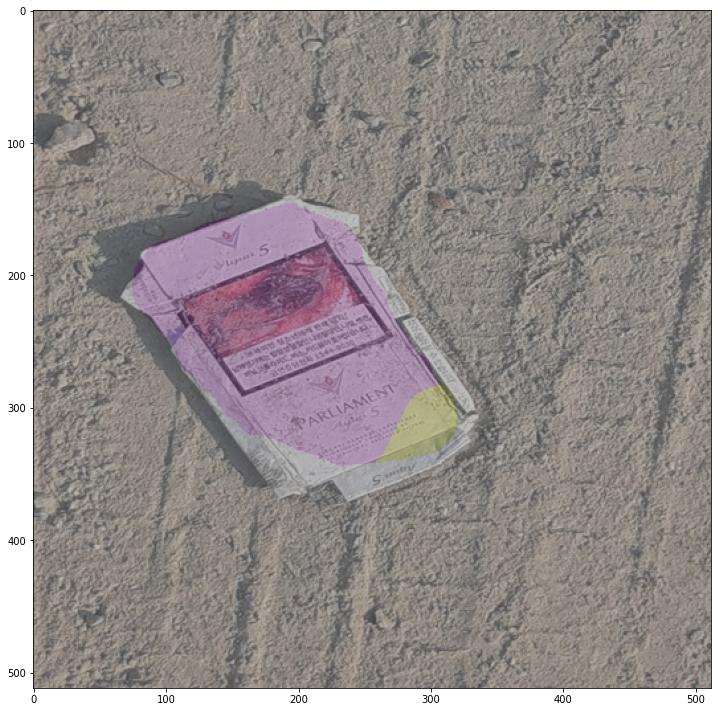

In [15]:
img = mmcv.imread(sample_img)

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)